## NBA Career Prediction Experiment

In [817]:
experiment_label = 'forest03'

### Aim:
* To revisit my earlier Random Forest, and attempt to improve it by applying HyperOpt tuning and examiniation of partial dependece and LIME.
* Previous best Random Forest run was 'rforest03' (oops... I should have called this current on '04' - lucky I dropped the 'r'.
* Kaggle test result of that was 0.70360.


### Findings:

RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        min_samples_leaf=7, n_estimators=650
                                        
Results 
* train, val auc: 0.75, 0.70
* test Kaggle 0.70705
* this is a tiny improvement, and still way short of the results of our logreg, poly logreg and SVC work.


## Set up

In [818]:
import pandas as pd
import numpy as np
from joblib import dump, load  # simpler than pickle!
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [819]:
#load data

data_path = '../data/raw/uts-advdsi-nba-career-prediction'

train_raw = pd.read_csv(data_path + '/train.csv')
test_raw = pd.read_csv(data_path + '/test.csv')


In [820]:
#shapes & head

print(train_raw.shape)
print(test_raw.shape)

train_raw.head()

(8000, 22)
(3799, 21)


,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,10556,3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,...,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,5342,3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,...,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,5716,3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,...,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,13790,3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,...,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,5470,3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,...,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1


In [821]:
test_raw.head()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,1,0,56,9.1,4.0,1.6,3.7,43.7,0.1,0.3,...,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,8194,1,43,19.3,10.1,3.7,8.1,46.0,0.6,1.7,...,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,0.0,1.8
2,3,2,82,33.9,11.3,4.9,10.6,45.6,0.5,1.9,...,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,8196,3,86,44.7,18.8,6.8,15.9,42.9,0.5,1.8,...,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,8197,4,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,...,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9


In [822]:
# info
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id_old       8000 non-null   int64  
 1   Id           8000 non-null   int64  
 2   GP           8000 non-null   int64  
 3   MIN          8000 non-null   float64
 4   PTS          8000 non-null   float64
 5   FGM          8000 non-null   float64
 6   FGA          8000 non-null   float64
 7   FG%          8000 non-null   float64
 8   3P Made      8000 non-null   float64
 9   3PA          8000 non-null   float64
 10  3P%          8000 non-null   float64
 11  FTM          8000 non-null   float64
 12  FTA          8000 non-null   float64
 13  FT%          8000 non-null   float64
 14  OREB         8000 non-null   float64
 15  DREB         8000 non-null   float64
 16  REB          8000 non-null   float64
 17  AST          8000 non-null   float64
 18  STL          8000 non-null   float64
 19  BLK   

In [823]:
print(train_raw.where(train_raw < 0).count())

Id_old            0
Id                0
GP                2
MIN               0
PTS               0
FGM               0
FGA               0
FG%               0
3P Made        1629
3PA            1658
3P%             878
FTM               0
FTA               0
FT%               1
OREB              0
DREB              0
REB               0
AST               0
STL               0
BLK            1048
TOV               0
TARGET_5Yrs       0
dtype: int64


In [824]:
len(train_raw[(train_raw['3P%'] < 0) | (train_raw['3P Made'] < 0) | (train_raw['3PA'] < 0)])

2192

In [825]:
len(train_raw[(train_raw['3P%'] < 0) | (train_raw['3P Made'] < 0) | (train_raw['3PA'] < 0) | (train_raw['BLK'] < 0)])

3046

In [826]:
#variable descriptions
train_raw.describe()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,6856.971000,7798.50000,62.777875,18.576663,7.267087,2.807037,6.231213,44.608900,0.264525,0.816563,...,1.947787,71.365825,1.077838,2.168500,3.245300,1.624513,0.648688,0.245212,1.257762,0.833625
std,3977.447579,2309.54541,17.118774,8.935263,4.318732,1.693373,3.584559,6.155453,0.384093,1.060964,...,1.252352,10.430447,0.785670,1.392224,2.085154,1.355986,0.407626,0.821037,0.723270,0.372440
min,4.000000,3799.00000,-8.000000,2.900000,0.800000,0.300000,0.800000,21.300000,-1.100000,-3.100000,...,0.000000,-13.300000,0.000000,0.200000,0.300000,0.000000,0.000000,-17.900000,0.100000,0.000000
25%,3413.750000,5798.75000,51.000000,12.000000,4.100000,1.600000,3.600000,40.400000,0.000000,0.100000,...,1.000000,65.000000,0.500000,1.100000,1.700000,0.700000,0.300000,0.100000,0.700000,1.000000
50%,6787.500000,7798.50000,63.000000,16.800000,6.300000,2.400000,5.400000,44.400000,0.300000,0.800000,...,1.700000,71.400000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000,1.000000
75%,10299.250000,9798.25000,74.000000,23.500000,9.500000,3.700000,8.100000,48.700000,0.500000,1.500000,...,2.600000,77.500000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,1.000000
max,13798.000000,11798.00000,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,...,11.100000,168.900000,5.500000,11.000000,15.900000,12.800000,3.600000,18.900000,5.300000,1.000000


In [827]:
test_raw.describe()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
count,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,...,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000
mean,7010.614109,1899.000000,62.853909,18.650224,7.328034,2.835404,6.302580,44.599079,0.255962,0.796920,...,1.399842,1.953567,71.612924,1.096025,2.179495,3.275783,1.636483,0.653593,0.257726,1.257910
std,3954.173641,1096.821164,17.151740,8.727259,4.294724,1.688427,3.579221,6.040168,0.380987,1.052862,...,0.926140,1.250376,10.457336,0.785678,1.371935,2.070646,1.335496,0.410573,0.639660,0.712449
min,1.000000,0.000000,6.000000,3.700000,0.700000,0.300000,0.800000,25.100000,-1.000000,-2.700000,...,0.000000,0.000000,23.700000,0.000000,0.200000,0.300000,0.000000,0.000000,-7.100000,0.100000
25%,3644.000000,949.500000,51.000000,12.200000,4.200000,1.600000,3.700000,40.500000,0.000000,0.100000,...,0.700000,1.000000,65.000000,0.500000,1.200000,1.800000,0.600000,0.400000,0.100000,0.700000
50%,7062.000000,1899.000000,63.000000,17.000000,6.400000,2.500000,5.500000,44.600000,0.300000,0.800000,...,1.200000,1.700000,71.500000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000
75%,10402.500000,2848.500000,74.000000,23.300000,9.400000,3.700000,8.100000,48.500000,0.500000,1.500000,...,1.900000,2.600000,78.000000,1.500000,2.900000,4.300000,2.300000,0.900000,0.400000,1.600000
max,13792.000000,3798.000000,126.000000,68.000000,33.000000,13.400000,26.200000,74.600000,1.600000,4.300000,...,7.800000,9.800000,127.100000,6.900000,12.000000,18.500000,9.000000,2.700000,14.800000,5.200000


## Decisions

We will retain all potential features, when using non-linear models.

We will set negative values to 

and TARGET_5Yrs is our target.

## Cleaning

In [828]:
train = train_raw.copy()
test = test_raw.copy()

In [829]:
cols_drop = ['Id_old', 'Id'] #, 'MIN', 'FGM', 'FGA', 'TOV', '3PA', 'FTM', 'FTA', 'REB']
train.drop(cols_drop, axis=1, inplace=True)
test.drop(cols_drop, axis=1, inplace=True)

In [830]:
train.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1


In [831]:
test.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,56,9.1,4.0,1.6,3.7,43.7,0.1,0.3,7.3,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,43,19.3,10.1,3.7,8.1,46.0,0.6,1.7,35.1,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,0.0,1.8
2,82,33.9,11.3,4.9,10.6,45.6,0.5,1.9,44.8,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,86,44.7,18.8,6.8,15.9,42.9,0.5,1.8,13.5,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,38.7,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9


In [832]:
# Negative values do not make sense in this context

def clean_negatives(strategy, df):
    
    if strategy=='abs':
        df = abs(df)
    if strategy=='null':
        df[df < 0] = None
    if strategy=='mean':
        df[df < 0] = None
        df.fillna(df.mean(), inplace=True)     
    if strategy=='median':
        df[df < 0] = None
        df.fillna(df.median(), inplace=True)   
    
    return(df)


In [833]:
negatives_strategy = 'abs'

train = clean_negatives(negatives_strategy, train)
test = clean_negatives(negatives_strategy, test)


In [834]:
train.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,80.0,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1.0
1,75.0,21.8,10.5,4.2,7.9,55.1,0.3,1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1.0
2,85.0,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1.0
3,63.0,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1.0
4,63.0,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1.0


In [835]:
test.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,56.0,9.1,4.0,1.6,3.7,43.7,0.1,0.3,7.3,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,43.0,19.3,10.1,3.7,8.1,46.0,0.6,1.7,35.1,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,0.0,1.8
2,82.0,33.9,11.3,4.9,10.6,45.6,0.5,1.9,44.8,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,86.0,44.7,18.8,6.8,15.9,42.9,0.5,1.8,13.5,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,58.0,12.3,4.7,1.6,4.0,40.0,0.5,1.7,38.7,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,0.4,0.9


In [836]:
train_target = train.pop('TARGET_5Yrs')

In [837]:
#examine shapes

print('train:' + str(train.shape))
print('test:' + str(test.shape))

train:(8000, 19)
test:(3799, 19)


In [838]:
# target class balance check
from collections import Counter

counter = Counter(train_target)
print(counter)

Counter({1.0: 6669, 0.0: 1331})


## Feature engineering - Gaussian clusters

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
def optimal_gaussian_clusters(X, min, max):
    
    import numpy as np
    import itertools

    from scipy import linalg
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    from sklearn import mixture

    lowest_bic = np.infty
    bic = []
    n_components_range = range(min, max)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                                  'darkorange'])
    clf = best_gmm
    bars = []

    # Plot the BIC scores
    plt.figure(figsize=(8, 6))
    spl = plt.subplot(2, 1, 1)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model')
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)

    # Plot the winner
    splot = plt.subplot(2, 1, 2)
    Y_ = clf.predict(X)
    for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                               color_iter)):
        v, w = linalg.eigh(cov)
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180. * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(.5)
        splot.add_artist(ell)

    plt.xticks(())
    plt.yticks(())
    plt.title(f'Selected GMM: {best_gmm.covariance_type} model, '
              f'{best_gmm.n_components} components')
    plt.subplots_adjust(hspace=.35, bottom=.02)
    plt.show()
    

In [ ]:
optimal_gaussian_clusters(X, 1, 7)

In [ ]:
gm = GaussianMixture(n_components=2, 
                     covariance_type = 'full',  #{‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’
                     tol = 0.0001,
                     init_params = 'kmeans',  #{‘kmeans’, ‘random’}, default=’kmeans’
                     n_init = 1,
                     max_iter = 100,
                     random_state=8,
                    )

In [ ]:
gm.fit(X_train)

In [ ]:
gm.predict_proba(X_train)

In [ ]:
gm.predict_proba(X_val)

### Decision about clusters:

TBC


In [ ]:
# TBC

# Modelling

In [839]:
#transformations

# scaling - not for tree-based model


In [840]:
# set training data and validation data

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train, train_target, test_size=0.2, random_state=8)


In [841]:
# Define model

from sklearn.ensemble import RandomForestClassifier

initial_model = RandomForestClassifier(class_weight='balanced',
                               random_state=8)

In [842]:
# re-index the y_train, since xgboost has deprecated the use_label_encoder function

y_train.index = range(0, len(y_train), 1)


In [843]:
# Fit model

initial_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=8)

In [844]:
#dump(initial_model,  '../models/aj_' + experiment_label + '_initial.joblib')

In [845]:
y_train_preds = initial_model.predict(X_train)
y_val_preds = initial_model.predict(X_val)

In [846]:
def eval_report(X, true, pred):
    
    import numpy as np
    import pandas as pd
    from sklearn import metrics

    unique_label = np.unique([true, pred])
    cmtx = pd.DataFrame(
        metrics.confusion_matrix(true, pred, labels=unique_label), 
        index=['true:{:}'.format(x) for x in unique_label], 
        columns=['pred:{:}'.format(x) for x in unique_label]
    )
    print("Confusion matrix:")
    print(cmtx)
    print("")
    print(metrics.classification_report(true, pred))
    print("")
    print('ROC AUC: {:.4f}'.format(metrics.roc_auc_score(true, pred), ))


In [847]:
# model performance on training data

eval_report(X_train, y_train, y_train_preds)

Confusion matrix:
          pred:0.0  pred:1.0
true:0.0      1074         0
true:1.0         0      5326

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1074
         1.0       1.00      1.00      1.00      5326

    accuracy                           1.00      6400
   macro avg       1.00      1.00      1.00      6400
weighted avg       1.00      1.00      1.00      6400


ROC AUC: 1.0000


In [848]:
# model performance on validation data

eval_report(X_val, y_val, y_val_preds)

Confusion matrix:
          pred:0.0  pred:1.0
true:0.0        10       247
true:1.0        13      1330

              precision    recall  f1-score   support

         0.0       0.43      0.04      0.07       257
         1.0       0.84      0.99      0.91      1343

    accuracy                           0.84      1600
   macro avg       0.64      0.51      0.49      1600
weighted avg       0.78      0.84      0.78      1600


ROC AUC: 0.5146


## Model tuning

In [849]:
# class imbalance pipeline

!pip install imblearn

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

## Hyperparameter optimisation search

In [850]:
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
from hyperopt.pyll.base import scope


In [862]:
def objective(space):
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import RepeatedStratifiedKFold
      
    forest = RandomForestClassifier(class_weight='balanced',
        random_state=8,
        min_samples_leaf = int(space['min_samples_leaf']),
        n_estimators = int(space['n_estimators']),
        max_depth = int(space['max_depth'])
    )
    
    # Define model pipeline
    model = Pipeline([
        #('over', SMOTE(sampling_strategy=0.5)),
        #('under', RandomUnderSampler(sampling_strategy=0.75)),
        ('model', forest)
    ])
    
    cv = RepeatedStratifiedKFold(
    n_splits=10, n_repeats=3, random_state=8)
    
    acc = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc").mean()

    return{'loss': 1-acc, 'status': STATUS_OK }

In [867]:
space = {
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 7, 9, 1)),
    'n_estimators' : scope.int(hp.quniform('n_estimators', 600, 700, 50)),
    'max_depth' : scope.int(hp.quniform('max_depth', 4, 6, 1)),
    'min_child_weight' : scope.int(hp.quniform('min_child_weight', 2, 4, 1))
}


In [869]:
# Previous runs:

#    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),
#    'n_estimators' : scope.int(hp.quniform('n_estimators', 200, 500, 50)),
#    'max_depth' : scope.int(hp.quniform('max_depth', 5, 15, 1)),
#    'min_child_weight' : scope.int(hp.quniform('min_child_weight', 1, 8, 1))
# Best:  {'max_depth': 5.0, 'min_child_weight': 2.0, 'min_samples_leaf': 1.0, 'n_estimators': 500.0}
# best loss: 0.30893317075013205

#then
#    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 4, 7, 1)),
#    'n_estimators' : scope.int(hp.quniform('n_estimators', 500, 700, 50)),
#    'max_depth' : scope.int(hp.quniform('max_depth', 2, 6, 1)),
#    'min_child_weight' : scope.int(hp.quniform('min_child_weight', 1, 3, 1))
#Best:  {'max_depth': 5.0, 'min_child_weight': 3.0, 'min_samples_leaf': 7.0, 'n_estimators': 650.0}
#best loss: 0.3084636764225881    

In [870]:
best = fmin(
    fn=objective,   
    space=space,       
    algo=tpe.suggest,       
    max_evals=30
)


100%|██████████| 30/30 [44:05<00:00, 88.19s/trial, best loss: 0.3084636764225881] 


In [871]:
print("Best: ", best)

Best:  {'max_depth': 5.0, 'min_child_weight': 3.0, 'min_samples_leaf': 7.0, 'n_estimators': 650.0}


## Fit best model

In [872]:
### and here is where we take the best hyperparamters from the hyperparameter search and fit the model again.

forest_2 = RandomForestClassifier(class_weight='balanced',
    random_state=8,
    min_samples_leaf = int(best['min_samples_leaf']),
    n_estimators = int(best['n_estimators']),
    max_depth = int(best['max_depth'])
)  

# Define model pipeline
best_model = Pipeline([
    #('over', SMOTE(sampling_strategy=0.5)),
    #('under', RandomUnderSampler(sampling_strategy=0.75)),
    ('model', forest_2)
])

best_model.fit(X_train, y_train)


Pipeline(steps=[('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        min_samples_leaf=7, n_estimators=650,
                                        random_state=8))])

In [893]:
#save model to file

dump(best_model,  '../models/aj_' + experiment_label + '_best.joblib')

['../models/aj_forest03_best.joblib']

In [874]:
#predictions for train & validation sets

y_train_preds = best_model.predict(X_train)
y_val_preds = best_model.predict(X_val)

## Evaluation

In [875]:
# model performance on training data

eval_report(X_train, y_train, y_train_preds)

Confusion matrix:
          pred:0.0  pred:1.0
true:0.0       717       357
true:1.0      1605      3721

              precision    recall  f1-score   support

         0.0       0.31      0.67      0.42      1074
         1.0       0.91      0.70      0.79      5326

    accuracy                           0.69      6400
   macro avg       0.61      0.68      0.61      6400
weighted avg       0.81      0.69      0.73      6400


ROC AUC: 0.6831


In [876]:
# model performance on validation data

eval_report(X_val, y_val, y_val_preds)

Confusion matrix:
          pred:0.0  pred:1.0
true:0.0       158        99
true:1.0       442       901

              precision    recall  f1-score   support

         0.0       0.26      0.61      0.37       257
         1.0       0.90      0.67      0.77      1343

    accuracy                           0.66      1600
   macro avg       0.58      0.64      0.57      1600
weighted avg       0.80      0.66      0.70      1600


ROC AUC: 0.6428


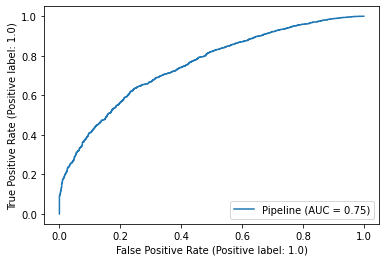

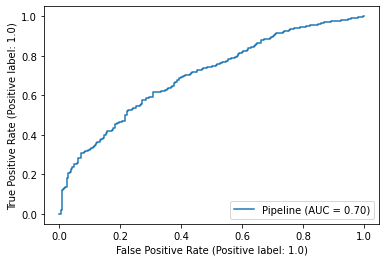

In [877]:
# ROC curves

import matplotlib.pyplot as plt  
from sklearn import metrics
metrics.plot_roc_curve(best_model, X_train, y_train)
plt.show() 
metrics.plot_roc_curve(best_model, X_val, y_val)
plt.show() 

## Variable importance by permutation


In [878]:
from sklearn.inspection import permutation_importance

In [879]:
r = permutation_importance(
    best_model, X_train, y_train,
    n_repeats=30,
    random_state=8
)

In [880]:
for i in r.importances_mean.argsort()[::-1]:
     print(f"{X_train.columns[i]}: {r.importances_mean[i]:.5f}")

FG%: 0.00869
GP: 0.00315
3P%: 0.00232
3PA: 0.00224
FT%: 0.00217
FGA: 0.00161
3P Made: 0.00124
TOV: 0.00064
BLK: 0.00011
STL: -0.00032
AST: -0.00053
DREB: -0.00107
FTM: -0.00136
FTA: -0.00356
FGM: -0.00421
REB: -0.00528
OREB: -0.00565
PTS: -0.00573
MIN: -0.00648


## Partial dependence plot

In [881]:
from sklearn.inspection import plot_partial_dependence

In [885]:
def plot_pdp(model, X, feature_name, feature_cols, target_classes):
    
    feature_index = feature_cols.get_loc(feature_name)
    
    print(f"PDP for `{feature_cols[feature_index]}` with {target_classes}")
    
    for target_class in target_classes:
        plot_partial_dependence(model, X, features=[feature_index], target=target_class)

In [886]:
target_classes=[1]

PDP for `FG%` with [1]
PDP for `MIN` with [1]
PDP for `PTS` with [1]
PDP for `OREB` with [1]
PDP for `FGM` with [1]
PDP for `FTA` with [1]


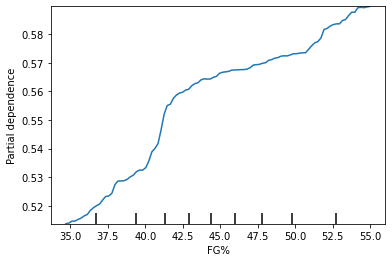

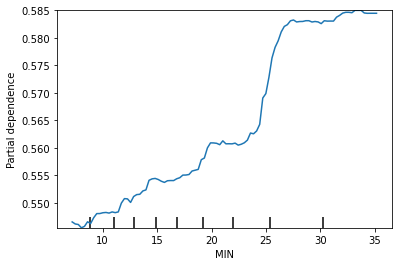

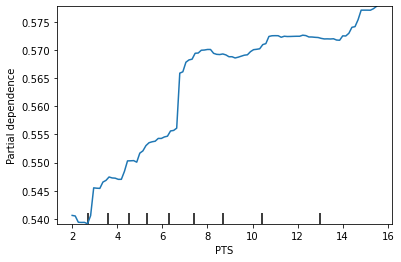

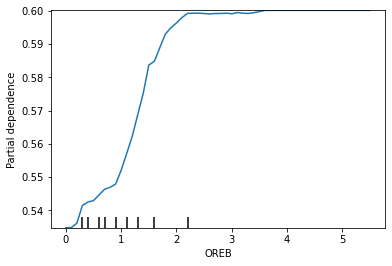

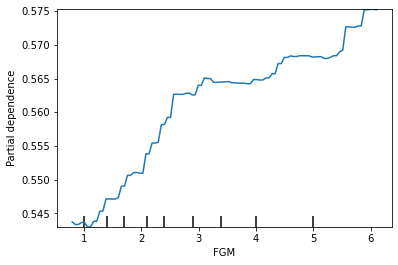

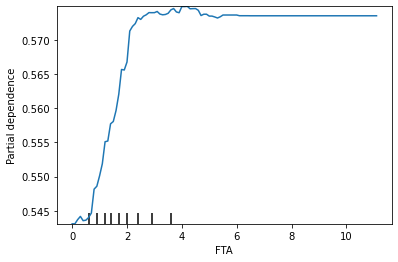

In [887]:
features = ['FG%', 'MIN', 'PTS', 'OREB', 'FGM', 'FTA']

for f in features:
    plot_pdp(model=best_model, X=X_train, feature_name=f, feature_cols=X_train.columns, target_classes=target_classes)

## Explain specific observations with LIME

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
lime_explainer = LimeTabularExplainer(X_train,
      feature_names=X_train.columns,
      class_names=target_classes,
      mode='classification',
      discretize_continuous=False
)

In [ ]:
# Choose observation


obs_index = 0


In [ ]:
def please_explain(model, X, obs):
    exp = lime_explainer.explain_instance(
        X[obs], 
        model.predict_proba, 
        top_labels=1,
        num_features=20)

In [ ]:
exp = please_explain(best_model, X_val, ob_index)
exp.show_in_notebook()

# Apply to test data for submission

In [888]:
y_test_preds = best_model.predict(test)


In [889]:
y_test_probs = best_model.predict_proba(test)

In [890]:
submission = pd.DataFrame({'Id': range(0,3799), 'TARGET_5Yrs': [p[1] for p in y_test_probs]})

In [891]:
submission.head()

,Id,TARGET_5Yrs
0,0,0.448396
1,1,0.472846
2,2,0.766077
3,3,0.830503
4,4,0.418610


In [892]:
submission.to_csv('../reports/aj_' + experiment_label + 'submission.csv',
                 index=False,
                 )